In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DownsampleLayer(nn.Module):
    """
    定义下采样忽的网络层
    """
    def __init__(self, in_chanel, out_chanel):
        super(DownsampleLayer, self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels=in_chanel, out_channels=out_chanel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_chanel, out_channels=out_chanel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(inplace=True)
        )
        self.dowmsample = nn.Sequential(
            # 利用步长实现向下池化
            # nn.MaxPool2d(2)
            nn.Conv2d(in_channels=out_chanel, out_channels=out_chanel, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """

        :param
            x: 输入的图像数据
        :return:
            out:输出到深层
            out_2:输出到下一层
        """
        out = self.conv_relu(x)
        out_2 = self.dowmsample(out)
        return out, out_2


class UpsampleLayer(nn.Module):
    """
    定义上采样的网络层
    """
    def __init__(self, in_chanel, out_chanel):
        super(UpsampleLayer, self).__init__()
        self.up_conv_relu = nn.Sequential(
            nn.Conv2d(in_channels=in_chanel, out_channels=out_chanel*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chanel * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_chanel*2, out_channels=out_chanel*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_chanel * 2),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_chanel*2, out_channels=out_chanel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_chanel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, out):
        """

        :param
            x:图片数据
            out: 对应上采样层的浅层特征
        :return:
             cat_out：上采样层的千层特征和下采样层的抽象特征拼接
        """
        x = self.up_conv_relu(x)
        x = self.upsample(x)
        cat_out = torch.cat([x, out], dim=1)
        return cat_out


class Unet(nn.Module):
    """
    定义Unet网络结构
    """
    def __init__(self):
        super(Unet, self).__init__()
        # 定义下采样层的网络层结构
        self.d1 = DownsampleLayer(1, 64)
        self.d2 = DownsampleLayer(64, 128)
        self.d3 = DownsampleLayer(128, 256)
        self.d4 = DownsampleLayer(256, 512)

        #定义上采样层的网络层结构
        self.u1 = UpsampleLayer(512, 512)
        self.u2 = UpsampleLayer(1024, 256)
        self.u3 = UpsampleLayer(512, 128)
        self.u4 = UpsampleLayer(256, 64)
        # 输出
        self.o = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        out_1, out1 = self.d1(x)
        out_2, out2 = self.d2(out1)
        out_3, out3 = self.d3(out2)
        out_4, out4 = self.d4(out3)

        out5 = self.u1(out4, out_4)
        out6 = self.u2(out5, out_3)
        out7 = self.u3(out6, out_2)
        out8 = self.u4(out7, out_1)
        out = self.o(out8)

        return out

In [2]:
from torch.utils.data import Dataset
import PIL.Image as Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import numpy as np


def train_dataset(img_root, label_root):
    imgs = []
    n = len(os.listdir(img_root))
    for i in range(n):
        img = os.path.join(img_root, "{}.png".format(i))

        label = os.path.join(label_root, "{}.png".format(i))
        imgs.append((img, label))
    return imgs


def test_dataset(img_root):
    imgs = []
    n = len(os.listdir(img_root))
    for i in range(n):
        img = os.path.join(img_root, "{}.png".format(i))
        imgs.append(img)
    return imgs


class TrainDataset(Dataset):
    def __init__(self, img_root, label_root, transform=None, target_transform=None):
        imgs = train_dataset(img_root, label_root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, item):
        x_path, y_path = self.imgs[item]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)


class TestDataset(Dataset):
    def __init__(self, img_root, transform=None):
        imgs = test_dataset(img_root)
        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, item):
        img_path = self.imgs[item]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.imgs)

In [3]:
# 导入库
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


x_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

y_transform = transforms.ToTensor()

# 设置数据集路径
train_imageDir = "E:/人工智能实训/Unet--master/dataset/train/image/"
train_labelDir = "E:/人工智能实训/Unet--master/dataset/train/label/"
test_imageDir = "E:/人工智能实训/Unet--master/dataset/test/"

train_dataset = TrainDataset(train_imageDir, train_labelDir, transform=x_transform, target_transform=y_transform)
test_dataset = TestDataset(test_imageDir, transform=x_transform)

batch_size = 1 #1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
print(len(train_dataset))
print(len(train_loader))

30
30


In [4]:
# 定义一个函数来计算评价指标
def metrics(out, labels):
    # 将输出张量和标签张量转换为二进制形式
    out = torch.sigmoid(out) # 使用sigmoid函数将输出值映射到0-1之间
    out = (out > 0.5).float() # 使用阈值0.5将输出值转换为0或1
    labels = labels.float() # 将标签值转换为浮点数

    # 计算真正例、假正例、假负例和真负例的数量
    tp = (out * labels).sum() # 真正例是输出和标签都为1的像素的数量
    fp = (out * (1 - labels)).sum() # 假正例是输出为1但标签为0的像素的数量
    fn = ((1 - out) * labels).sum() # 假负例是输出为0但标签为1的像素的数量
    tn = ((1 - out) * (1 - labels)).sum() # 真负例是输出和标签都为0的像素的数量

    # 计算准确率、精确率、召回率和f1值
    accuracy = (tp + tn) / (tp + fp + fn + tn) # 准确率是正确预测的像素占总像素的比例
    precision = tp / (tp + fp) # 精确率是真正例占预测为正例的像素的比例
    recall = tp / (tp + fn) # 召回率是真正例占实际为正例的像素的比例
    f1 = 2 * precision * recall / (precision + recall) # f1值是精确率和召回率的调和平均数

    return accuracy, precision, recall, f1


In [7]:
#训练
def train(epochs, train_iter, lr):   
    loss_list = []
    acc_list = []

    model = Unet().to(device)
    #载入预训练模型
    #model.load_state_dict(torch.load(r"E:/UnetTest/checkpoints/GRUU-Net_85.pth"),strict=False)

    #选用adam优化器来训练
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #损失函数选用BCE损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        acc, p, r, f1_ = 0, 0, 0, 0

        for i, (features, labels) in enumerate(train_iter):
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            out = model(features)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            accuracy, precision, recall, f1 = metrics(out.cpu(), labels.cpu())
            acc += accuracy
            p += precision
            r += recall
            f1_ += f1
            
        train_loss = epoch_loss / (len(train_dataset)//batch_size)
        train_acc = acc / (len(train_dataset)//batch_size)
        train_pre = p / (len(train_dataset)//batch_size)
        train_recall = r / (len(train_dataset)//batch_size)
        train_f1 = f1_ / (len(train_dataset)//batch_size)
        #---------保存训练数据---------------
        loss_list.append(train_loss)
        acc_list.append(train_acc)
        
        # 打印训练信息
        print('epoch: {}\n训练损失: {:.4f}'.format(epoch+1, train_loss))
        # 打印评价指标
        print('准确率: {:.4f}, 精确率: {:.4f}, 召回率: {:.4f}, f1值: {:.4f}'.format(train_acc, train_pre, train_recall, train_f1))
        
        #----------------保存模型-------------------
        if np.mod(epoch+1, 5) == 0:
            torch.save(model.state_dict(), f'E:/UnetTest2/checkpoints/U-Net_{epoch+1}.pth')
            print("模型保存成功！")
    return loss_list, acc_list

In [8]:
epochs_num = 100
lr = 0.001

train_loss, train_acc = train(epochs_num, train_loader, lr)

epoch: 1
训练损失: 0.3577
准确率: 0.8671, 精确率: 0.9258, 召回率: 0.9016, f1值: 0.9119
epoch: 2
训练损失: 0.2424
准确率: 0.9102, 精确率: 0.9351, 召回率: 0.9510, f1值: 0.9428
epoch: 3
训练损失: 0.2148
准确率: 0.9143, 精确率: 0.9403, 召回率: 0.9507, f1值: 0.9453
epoch: 4
训练损失: 0.2060
准确率: 0.9150, 精确率: 0.9377, 召回率: 0.9547, f1值: 0.9459
epoch: 5
训练损失: 0.1974
准确率: 0.9171, 精确率: 0.9399, 召回率: 0.9550, f1值: 0.9472
模型保存成功！
epoch: 6
训练损失: 0.1954
准确率: 0.9170, 精确率: 0.9414, 召回率: 0.9530, f1值: 0.9470
epoch: 7
训练损失: 0.1859
准确率: 0.9208, 精确率: 0.9469, 召回率: 0.9519, f1值: 0.9492
epoch: 8
训练损失: 0.1835
准确率: 0.9214, 精确率: 0.9462, 召回率: 0.9536, f1值: 0.9497
epoch: 9
训练损失: 0.1830
准确率: 0.9210, 精确率: 0.9461, 召回率: 0.9531, f1值: 0.9495
epoch: 10
训练损失: 0.1758
准确率: 0.9244, 精确率: 0.9496, 召回率: 0.9538, f1值: 0.9515
模型保存成功！
epoch: 11
训练损失: 0.1723
准确率: 0.9258, 精确率: 0.9516, 召回率: 0.9535, f1值: 0.9524
epoch: 12
训练损失: 0.1728
准确率: 0.9249, 精确率: 0.9529, 召回率: 0.9506, f1值: 0.9517
epoch: 13
训练损失: 0.1733
准确率: 0.9247, 精确率: 0.9495, 召回率: 0.9545, f1值: 0.9517
epoch: 14
训练损失: 0.1707
准确率: 0.9

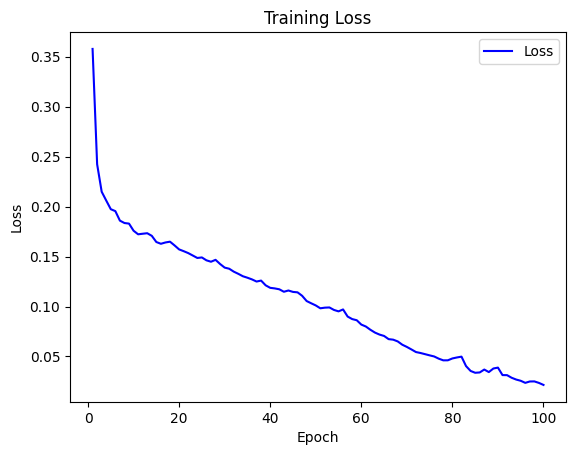

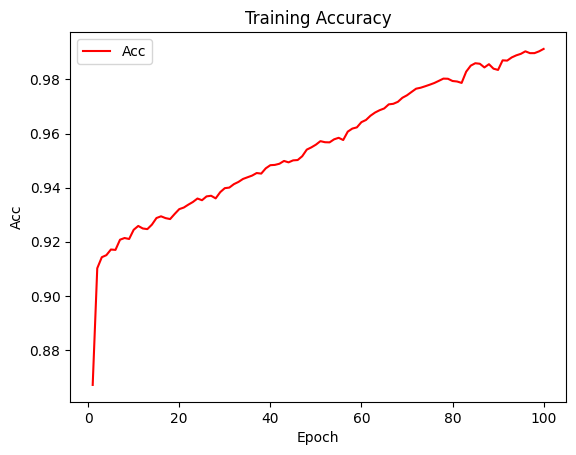

In [9]:
#画图
import matplotlib.pyplot as plt

def draw_loss_plot(epochs, train_loss):
    epochs = np.arange(epochs)
    plt.plot(epochs+1, train_loss, 'b-', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def draw_acc_plot(epochs, train_acc):
    epochs = np.arange(epochs)
    plt.plot(epochs+1, train_acc, 'r-', label='Acc')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()
    
draw_loss_plot(epochs_num, train_loss)
draw_acc_plot(epochs_num, train_acc)

In [12]:
def test(PATH):
    """
    模型测试
    :return:
    """
    model = Unet().to(device)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    with torch.no_grad():
        for index, x in enumerate(test_loader):
            x = x.to(device)
            y = model(x)

            img_y = torch.squeeze(y).cpu().numpy()
            img_y = img_y[:, :, np.newaxis]
            img = img_y[:, :, 0]
            img = np.interp(img, (img.min(), img.max()), (0, 255))
            im = Image.fromarray(img)
            if im.mode == "F":
                im = im.convert('L')
            im.save("E:/UnetTest2/TestImage/" + str(index) + "_predict.png")
        print("图片分割成功！")

In [13]:
Model_PATH = "E:/UnetTest2/checkpoints/U-Net_100.pth"
test(Model_PATH)

图片分割成功！


In [14]:
import cv2
#防止产生色差
def DealMyImg(img):
    b, g, r = cv2.split(img)
    img_new = cv2.merge([r,g,b])
    return img_new

Text(0.5, 1.0, 'new')

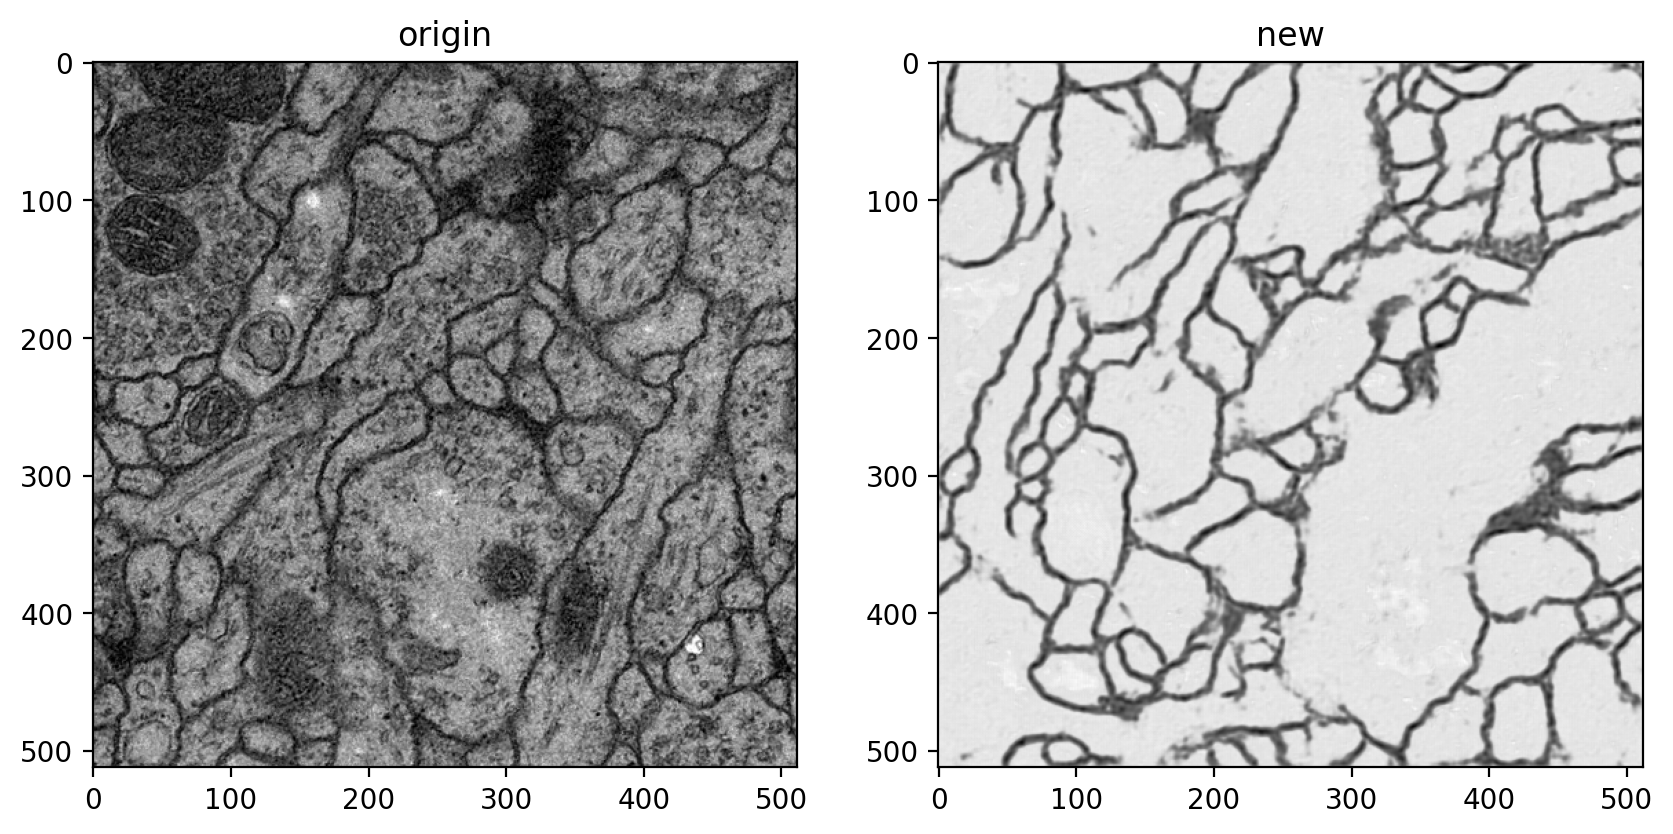

In [15]:
img_path = "E:/UnetTest2/test/24.png"
test_path = "E:/UnetTest2/TestImage/24_predict.png"
image_origin = cv2.imread(img_path, cv2.IMREAD_COLOR)
image_deal = cv2.imread(test_path, cv2.IMREAD_COLOR)

image_origin = DealMyImg(image_origin)
image_deal = DealMyImg(image_deal)

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,8),dpi=200)
axes[0].imshow(image_origin)
axes[0].set_title("origin")
axes[1].imshow(image_deal)
axes[1].set_title("new")

In [17]:
import cv2
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#防止产生色差
def DealMyImg(img):
    b, g, r = cv2.split(img)
    img_new = cv2.merge([r,g,b])
    return img_new
    
#模型应用
def applicate(model_path, img_path, target_path):
    """
    模型测试
    :return:
    """
    model = Unet().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        x_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
            ])
        img = Image.open(img_path)
        img = x_transform(img)
        
        x = img.to(device)
        x = x.reshape(1, 1, 512, -1)
        y = model(x)

        img_y = torch.squeeze(y).cpu().numpy()
        img_y = img_y[:, :, np.newaxis]
        img = img_y[:, :, 0]
        img = np.interp(img, (img.min(), img.max()), (0, 255))
        im = Image.fromarray(img)
        if im.mode == "F":
            im = im.convert('RGBA')
    
    image_origin = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_tgt = cv2.imread(target_path, cv2.IMREAD_COLOR)

    image_origin = DealMyImg(image_origin)
    image_tgt = DealMyImg(image_tgt)

    fig, axes=plt.subplots(nrows=1,ncols=3,figsize=(10,8),dpi=200)
    axes[0].imshow(image_origin)
    axes[0].set_title("origin")
    axes[1].imshow(im)
    axes[1].set_title("new")
    axes[2].imshow(image_tgt)
    axes[2].set_title("target")

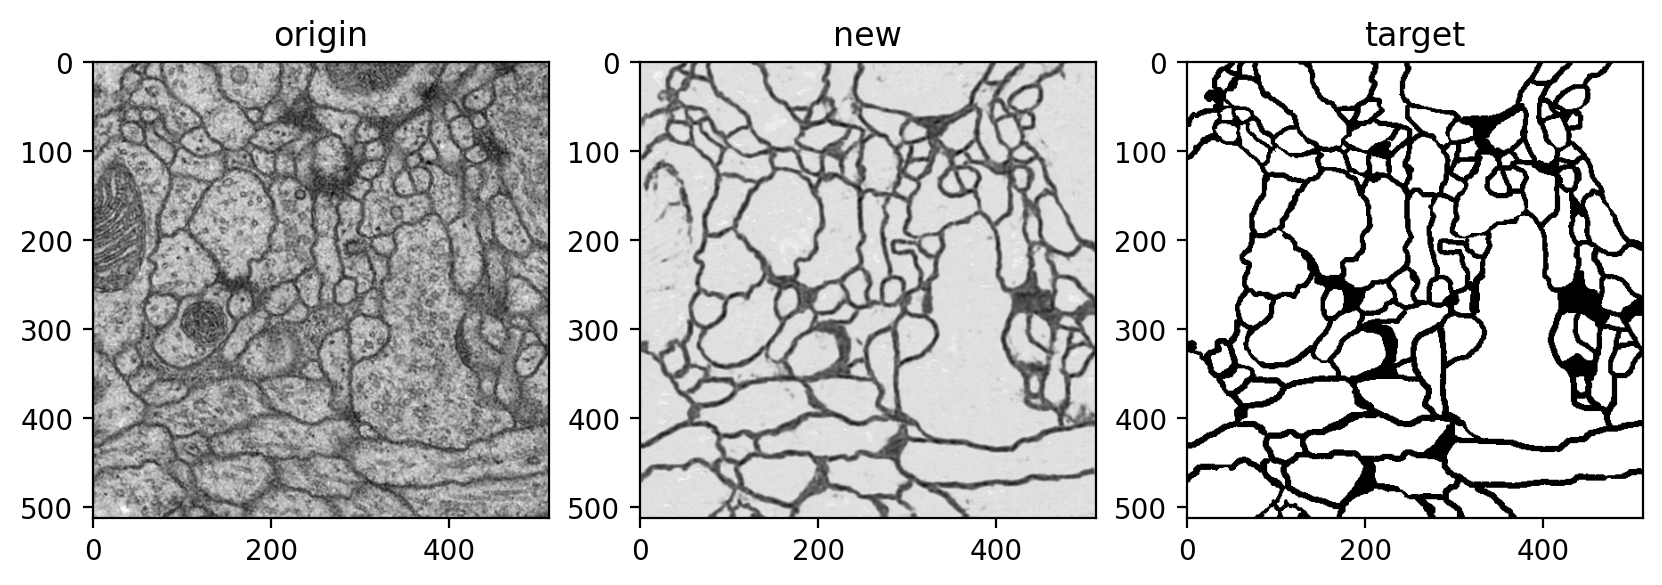

In [18]:
#输入图片
img_path = "E:/UnetTest2/train/image/10.png"
target_path = "E:/UnetTest2/train/label/10.png"
#导入模型
model_path = "E:/UnetTest2/checkpoints/U-Net_100.pth"

applicate(model_path, img_path, target_path)